In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append("../")

import pickle
from CONSTANTS import *
from Utils.helpers import *

## Data Collection - Specific to Normalized

In [38]:
import pandas as pd
dictionary_of_res = {}
mode = "normalized"

for year in years[:]:
    real_taus = []
    sigmas = []
    for tau in taus:
        if tau >= 1000 and tau <= 30000:
            with open(f"{path}Histograms/hist_{mode}_{year}_{tau}.pkl", "rb") as f:
                response = pickle.load(f)
            sigmas.append(1.0/response["sigma"]) # inverse STD
            real_taus.append(tau)
    
    log_taus = np.log(real_taus)
    log_b = np.log(sigmas)
    
    dict_df = {"b": sigmas, "log_b": log_b, "log_tau": log_taus, "tau": real_taus}
    dictionary_of_res[year] = pd.DataFrame(dict_df)

In [39]:
dictionary_of_res[2004].head()

,b,log_b,log_tau,tau
0,10.588136,2.359734,6.917706,1010
1,10.417715,2.343508,6.966024,1060
2,10.257729,2.328031,7.012115,1110
3,10.109081,2.313434,7.056175,1160
4,9.981999,2.300783,7.098376,1210


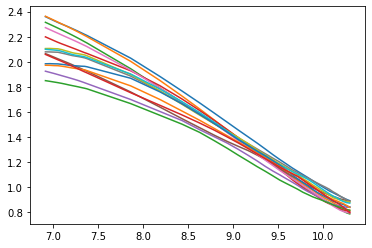

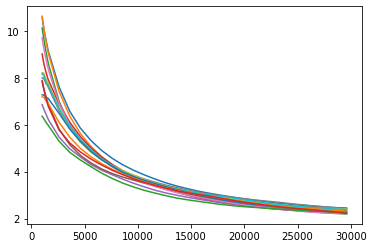

In [40]:
import matplotlib.pyplot as plt
for year in years:
    plt.plot(dictionary_of_res[year]["log_tau"], dictionary_of_res[year]["log_b"])
plt.show()

for year in years:
    plt.plot(dictionary_of_res[year]["tau"], dictionary_of_res[year]["b"])
plt.show()

In [41]:
print(dictionary_of_res[2008]["b"])

0     6.855795
1     6.793262
2     6.733810
3     6.673882
4     6.616040
5     6.562100
6     6.509426
7     6.458430
8     6.408566
9     6.358095
10    6.305645
11    6.253398
12    6.211791
13    5.472744
14    4.973184
15    4.627023
16    4.300732
17    4.061709
18    3.865177
19    3.675532
20    3.504126
21    3.352330
22    3.209589
23    3.095349
24    3.001969
25    2.912754
26    2.834497
27    2.760148
28    2.686324
29    2.627379
30    2.582032
31    2.533065
32    2.491175
33    2.437429
34    2.397375
35    2.372910
36    2.354279
37    2.341016
38    2.329862
39    2.318162
40    2.325979
Name: b, dtype: float64


## Custom Cross-Validation

In [42]:
import plotly.express as px

In [43]:
N_SPLITS = len(years)
from tabulate import tabulate
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from collections import defaultdict
df_test_std = defaultdict(list)
df_test_mse = defaultdict(list)
df_train_std = defaultdict(list)
df_train_mse = defaultdict(list)
# df_go = defaultdict(list)

years = np.array(years)
models = ["Poly5", "Poly2", "Linear", "Exponential Decay", "Power Law"]
for model_name in models:
        
        added_test_mse = []
        added_train_mse = []
        added_train_std = []
        added_test_std = []
        
        for year in years:
                
            average_train_mse = []
            average_test_mse = []
            
            if model_name == "Exponential Decay" or model_name == "Linear" or "Poly" in model_name:
                    x_s = dictionary_of_res[year]["tau"].tolist()
            else:
                    x_s = dictionary_of_res[year]["log_tau"].tolist()
                
            if model_name == "Linear" or "Poly" in model_name:
                    y_s = dictionary_of_res[year]["b"].tolist()
                    FLAG = False
            else:
                    FLAG = True
                    y_s = dictionary_of_res[year]["log_b"].tolist()
                
            x_s = np.array(x_s)
            y_s = np.array(y_s)
                
            if "Poly" not in model_name:
                    pipe = make_pipeline(LinearRegression())
            elif "Poly5" in model_name:
                    pipe = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
            elif "Poly2" in model_name:
                    pipe = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
            
            kf = KFold(n_splits=4)
            for train_index, test_index in kf.split(x_s):
                x_train, y_train = x_s[train_index], y_s[train_index]
                x_test, y_test = x_s[test_index], y_s[test_index]
                
                pipe.fit(x_train.reshape(-1,1), y_train.reshape(-1,1))
                y_train_pred = pipe.predict(x_train.reshape(-1,1))
                y_test_pred = pipe.predict(x_test.reshape(-1,1))
                
                if FLAG == True:
                    average_train_mse.append(mean_squared_error(np.exp(y_train_pred.reshape(-1,1)), np.exp(y_train)))
                else:
                    average_train_mse.append(mean_squared_error(y_train_pred.reshape(-1,1), y_train))
                
                if FLAG == True:
                    average_test_mse.append(mean_squared_error(np.exp(y_test_pred.reshape(-1,1)), np.exp(y_test)))
                else:
                    average_test_mse.append(mean_squared_error(y_test_pred.reshape(-1,1), y_test))
            
            added_train_mse.append(np.average(average_train_mse))
            added_train_std.append(np.std(average_train_mse))
            added_test_mse.append(np.average(average_test_mse))
            added_test_std.append(np.std(average_test_mse))
            
        df_train_mse[model_name].extend(added_train_mse)
        df_train_std[model_name].extend(added_train_std)
        df_test_mse[model_name].extend(added_test_mse)
        df_test_std[model_name].extend(added_test_std)
        

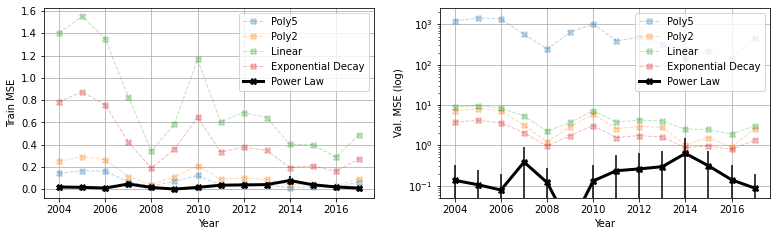

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,3.5))

df_pandas = pd.DataFrame(df_train_mse)
new_cols = []
for col in df_pandas.columns:
        new_cols.append(col)

for col in new_cols:
    if col == "Power Law":
        alpha = 1
        linewidth=3
        color = "black"
        ax1.plot(years, df_train_mse[col], linestyle="-", marker="X", linewidth=linewidth, label=col, alpha=alpha, color=color)
    else:
        alpha = 0.3
        linewidth=1
        ax1.plot(years, df_train_mse[col], linestyle="--", marker="X", linewidth=linewidth, label=col, alpha=alpha)
        
    if col == "Power Law":
        ax1.errorbar(years, df_train_mse[col],
                yerr = df_train_std[col],
                fmt ='.', color="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Year")
ax1.set_ylabel("Train MSE")

df_pandas = pd.DataFrame(df_test_mse)
new_cols = []
for col in df_pandas.columns:
    # if "Linear" not in col and "Poly" not in col:
    new_cols.append(col)

for col in new_cols:
    if col == "Power Law":
        alpha = 1
        linewidth=3
        ax2.plot(years, df_test_mse[col], linestyle="-", marker="X", linewidth=linewidth, label=col, alpha=alpha, color="black")

    else:
        alpha = 0.3
        linewidth=1
        ax2.plot(years, df_test_mse[col], linestyle="--", marker="X", linewidth=linewidth, label=col, alpha=alpha)

    if col == "Power Law":
        ax2.errorbar(years, df_test_mse[col],
                yerr = df_test_std[col],
                fmt ='.', color="black")

ax2.legend(loc='upper right')
ax2.grid()
ax2.set_xlabel("Year")
ax2.set_yscale("log")
ax2.set_ylim(0.05,)
ax2.set_ylabel("Val. MSE (log)")
plt.savefig("MAS.png", dpi=600, bbox_inches='tight')
plt.show()